In [19]:
import sys
# necessary to find ros packages
sys.path.append('/opt/ros/humble/local/lib/python3.10/dist-packages')

import numpy as np
import matplotlib.pyplot as plt
import yaml

from models.point import Point, RefPoint
from models.map import Map
from models.pose import Pose
from utils.classify_points import classify_points
from utils.extract_track_borders import extract_track_borders
from utils.get_center_line import get_center_line
from utils.trajectory_from_points import trajectory_from_path
import math

from path_find_algorithms.A_star.A_star import AStar
import csv
from skimage import measure
from scipy import ndimage
from skimage.segmentation import watershed
from skimage.feature import peak_local_max
import os

base_path = "../out/tracks/track_1"

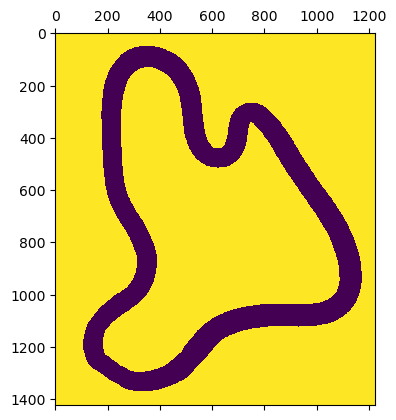

In [20]:
with open(os.path.join(base_path, "costmap/map.npy"),'rb') as f:
        occupancy_grid = np.load(f)

with (open(os.path.join(base_path, "costmap/map.yaml"), 'rb')) as f:
    occupancy_grid_config = yaml.safe_load(f)

    occupancy_grid = (occupancy_grid != 0) * 1

    resolution = occupancy_grid_config["resolution"]
    occupancy_map = Map(occupancy_grid, resolution, Point(occupancy_grid_config["origin_x"] - resolution, occupancy_grid_config["origin_y"] -resolution))

plt.matshow(occupancy_map.grid)

Track border extraction now super fast

In [21]:
track_contours = measure.find_contours(occupancy_map.grid, 0)
assert len(track_contours) == 2

# find track contours
for contour in track_contours:
    y_coord = np.empty(contour.shape[0], dtype=int)
    x_coord = np.empty(contour.shape[0],  dtype=int)
    for i, element in enumerate(contour):
        y_coord[i] = element[0]
        x_coord[i] = element[1]
    occupancy_map.grid[y_coord, x_coord] = 2

Using contours we can use the euclidean distance transform to get distance to track border

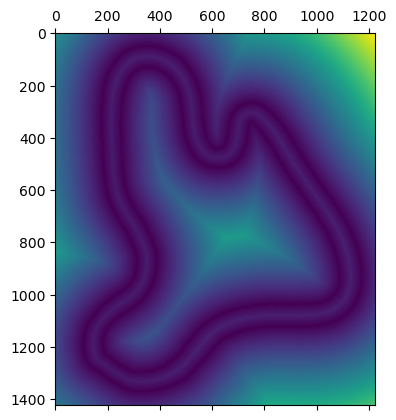

In [22]:
binarized_grid = occupancy_map.grid != 2
distances = ndimage.distance_transform_edt(binarized_grid)
plt.matshow(distances)

Now we apply watershed algorithm to the distance map. In detail we use distance map to form a valley, where the centerline (the points with ighest distance) create a rim with two valleys nearby. Then we fill both valleys. As soo as the water goes over the rim, we know we reached the centerline

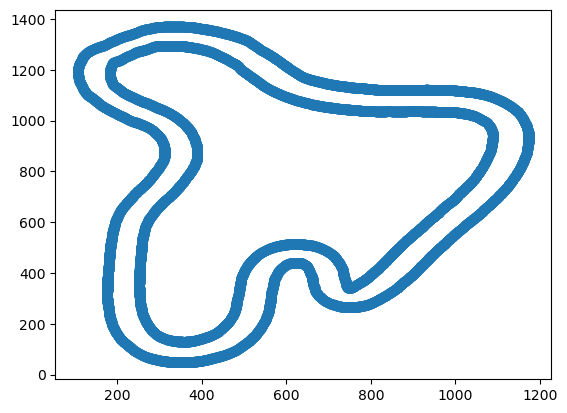

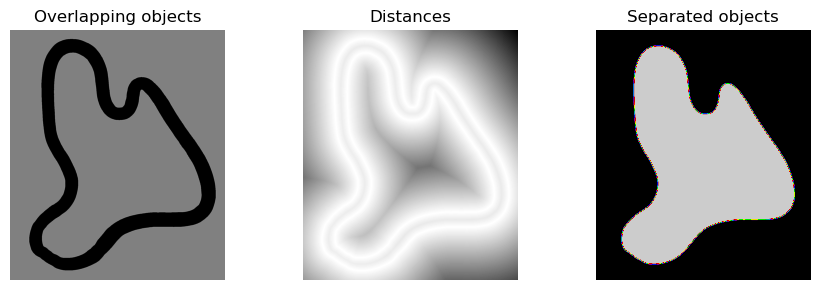

In [23]:
coords = peak_local_max(-distances, footprint=np.ones((3, 3)), labels=occupancy_map.grid)
plt.scatter([coord[1] for coord in coords], [coord[0] for coord in coords])
mask = np.zeros(distances.shape, dtype=bool)
mask[tuple(coords.T)] = True
markers, _ = ndimage.label(mask)
labels = watershed(distances, markers)

fig, axes = plt.subplots(ncols=3, figsize=(9, 3), sharex=True, sharey=True)
ax = axes.ravel()

ax[0].imshow(occupancy_map.grid, cmap=plt.cm.gray)
ax[0].set_title('Overlapping objects')
ax[1].imshow(-distances, cmap=plt.cm.gray)
ax[1].set_title('Distances')
ax[2].imshow(labels, cmap=plt.cm.nipy_spectral)
ax[2].set_title('Separated objects')

for a in ax:
    a.set_axis_off()

fig.tight_layout()
plt.show()

Finally, we can again use contour extraction to get final contour

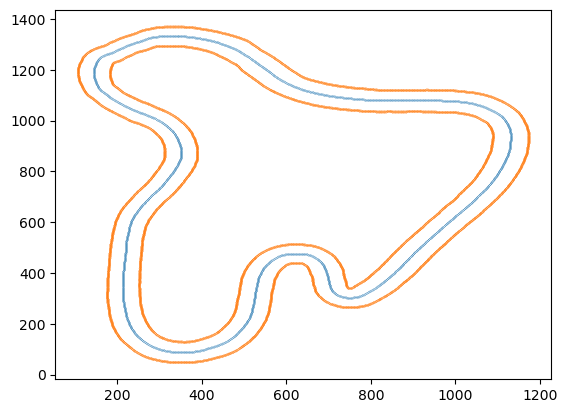

In [24]:
from skimage import measure
center_line = measure.find_contours(labels, 1)
assert len(center_line) == 1
center_line = center_line[0]
plt.scatter([coord[1] for coord in center_line], [coord[0] for coord in center_line], s=0.01)
plt.scatter([coord[1] for coord in coords], [coord[0] for coord in coords], s=0.01)
